# Project Setup

**Contributors**: Cam Suess / ~~Jeff Gibbens~~ (withdrew from course)

**Project Idea:** Predict Housing Prices
* In this project, we aim to predict the sale prices of residential homes using the Ames Housing Dataset. This dataset is a rich resource containing approximately 80 features that describe various aspects of residential properties in Ames, Iowa. By leveraging machine learning techniques, particularly regression models, we will explore how different features contribute to housing prices.

**Goal:** Develop a regression model that can predict house prices based on features like location, size, number of rooms, age, and other housing characteristics.

* Regression Analysis: Utilize regression models to predict continuous target variables

* Data Preprocessing: Handle missing values in the dataset, encode categorical variables, and scale numarical features

* Feature Engineering: Create new predictive features to enhance model performance

* Model Selection and Evaluation: Compare different models using appropriate metrics and select the best performing one

* Hyperparameter Tuning: Optimize model parameters to achieve better predictive performance.

**Dataset:** This dataset is a rich resource containing approximately 80 features that describe various aspects of residential properties in Ames, Iowa. It is comprised of detailed information about residential homes, including:

*  Location Features: Neighborhood, lot area, lot frontage

* Structural Attributes: Overall quality, number of rooms, square footage, year built

* Amenities: Garage size, pool presence, basement features

* Financial Information: Sale price, tax values.


# Library Setup

All necessary libraries for my project will be imported here:

In [118]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Data Acquisition

The Ames Housing Dataset was sourced from Kaggle and provides a comprehensive collection of residential property data:

* '#' of Samples: 2,930 residential properties

* Features: ~80 descriptive attributes

* Target Variable: SalePrice (the property's sale price)

First lets load the data into a pandas DataFrame for initial exploration and preprocessing.

In [119]:
data = pd.read_csv("data/AmesHousing.csv")

print(f"Dataset shape: {data.shape}")

data.head()

Dataset shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# Exploratory Data Analysis

The first thing I want to do is take a look at the data types. Here we can see that we have a mix of categorical and numerical data in our dataset.

In [120]:
data.dtypes.value_counts()

object     43
int64      28
float64    11
Name: count, dtype: int64

I am going to isolate the numerical features so I can visualize some of them with respect to our target SalePrice and identify some homes that I can drop from our dataset. 

In [121]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
numerical_features = numerical_features.drop('SalePrice')
print("Numerical Features:\n", numerical_features)

Numerical Features:
 Index(['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
       'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold'],
      dtype='object')


Splitting my data into "raw" train and test sets will allow me to perform various stages of data correcting before I train any models. It will also assure that my test data remains unseen by the models so they can better generalize when I test them.

In [122]:
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

In [123]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.1, random_state=42)

Lets visualize our target data first. We'll see that it is skewed so using a log-transform may be useful.

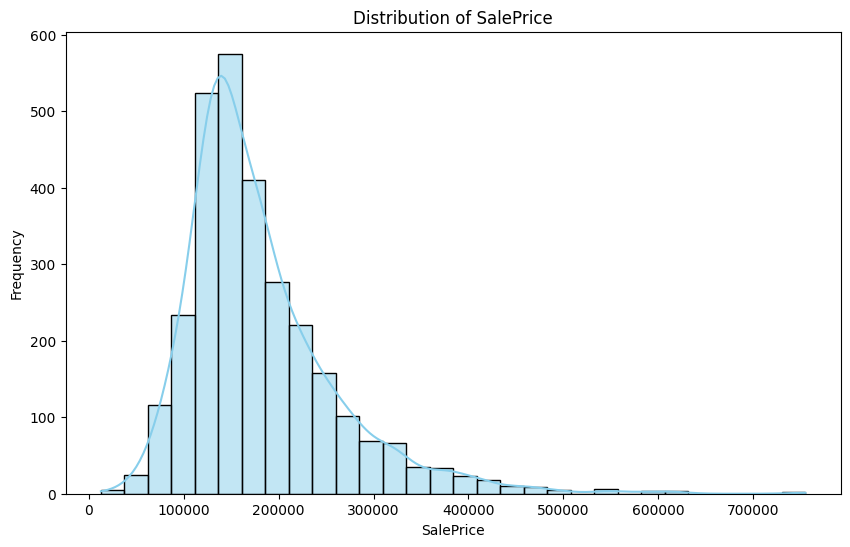

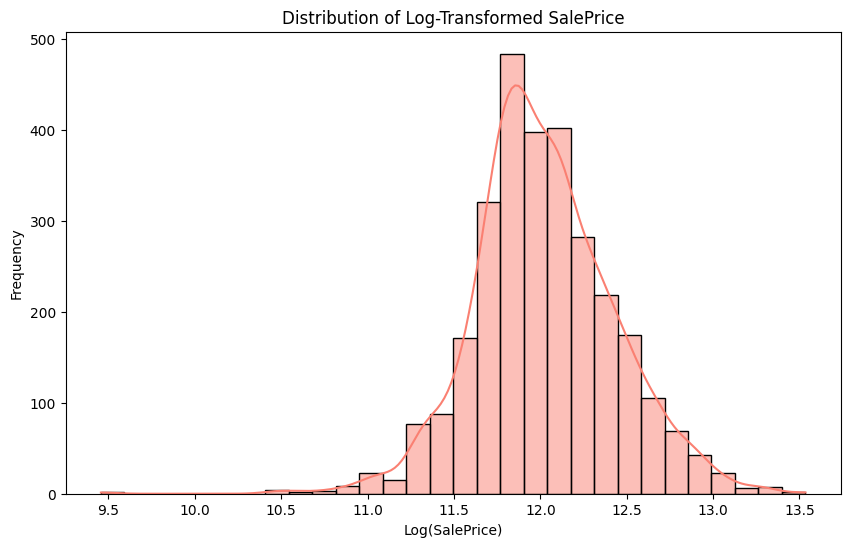

In [124]:
sale_price = data['SalePrice']
plt.figure(figsize=(10, 6))
sns.histplot(sale_price, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Apply log-transform
sale_price_log = np.log1p(sale_price)

plt.figure(figsize=(10, 6))
sns.histplot(sale_price_log, bins=30, kde=True, color='salmon', edgecolor='black')
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.show()

From the visuals above I think applying a log transformation will be the right call for the dataset.

# Outlier Detection

Next I am going to make some plots to better visualize some of the features with respect to the target SalePrice. I am also going to start collecting the order numbers of certain homes that I will drop if I think they are outliers and may affect my model if I leave them in.

* Outliers can significantly impact model performance, especially in regression tasks. Identifying and handling outliers ensures that the model captures the underlying data trends without being unduly influenced by extreme values.

In [125]:
homes_to_drop = set()

In [126]:
train_temp = X_train_raw.copy()
train_temp['SalePrice'] = y_train_raw

<Axes: xlabel='Lot Frontage', ylabel='SalePrice'>

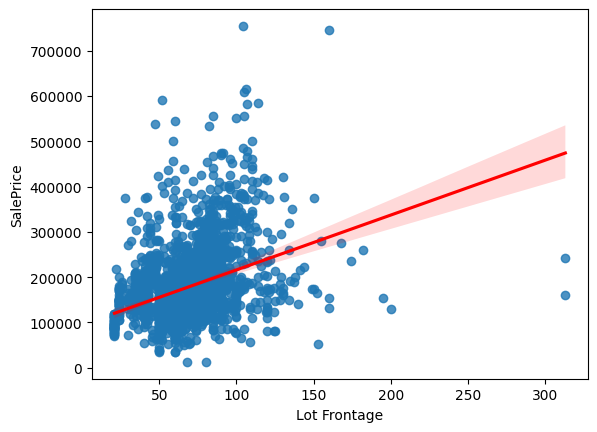

In [127]:
sns.regplot(x='Lot Frontage', y='SalePrice', data=train_temp, line_kws={"color": "red"})

There are clear outliers shown in the scatterplot above that I will want to drop for reduce the effect that they will have on my model. I will grab the two entries below.

In [128]:
train_temp.query('`Lot Frontage` > 300')

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1498,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1265,1266,535427070,20,RL,313.0,27650,Pave,NaN,IR2,HLS,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000


In [129]:
outliers_lot_frontage = train_temp.query('`Lot Frontage` > 300').index
for idx in outliers_lot_frontage:
    homes_to_drop.add(idx)

<Axes: xlabel='Lot Area', ylabel='SalePrice'>

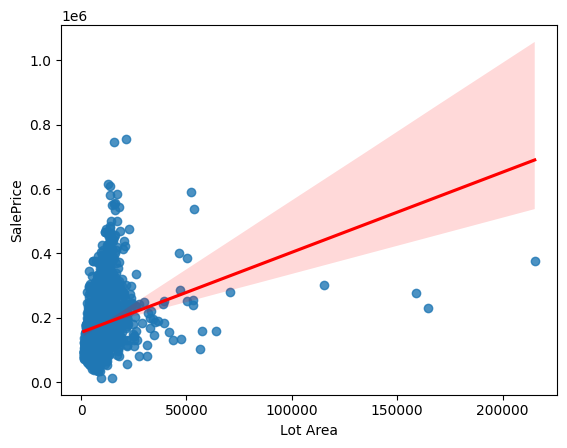

In [130]:
sns.regplot(x='Lot Area', y='SalePrice', data=train_temp, line_kws={"color": "red"})

Here we have a similar situation where we have outliers with very large lot areas but relatively low sale prices. I will grab those entries below to remove later.

In [131]:
train_temp.query('`Lot Area` > 100000')

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2071,2072,905301050,20,RL,NaN,115149,Pave,NaN,IR2,Low,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
2115,2116,906426060,50,RL,NaN,159000,Pave,NaN,IR2,Low,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
956,957,916176125,20,RL,150.0,215245,Pave,NaN,IR3,Low,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
1570,1571,916125425,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950


In [132]:
outliers_lot_area = train_temp.query('`Lot Area` > 100000').index
for idx in outliers_lot_area:
    homes_to_drop.add(idx)

<Axes: xlabel='Overall Qual', ylabel='SalePrice'>

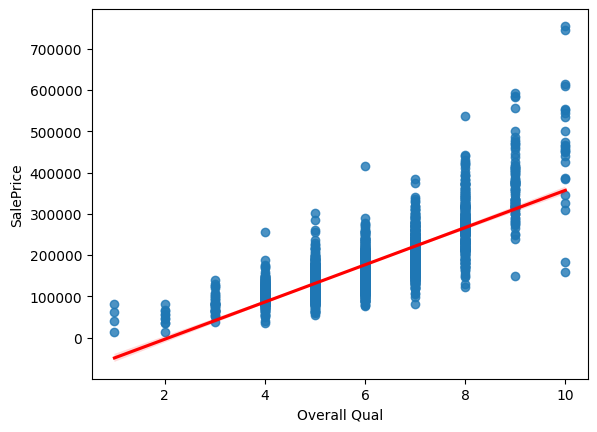

In [133]:
sns.regplot(x='Overall Qual', y='SalePrice', data=train_temp, line_kws={"color": "red"})

Above you can see that we have some homes that have an overall quality of 10  but they have low sale prices relative to their quality. There is also a home with an overall quality score of 6 but sold well above the rest that I will query to remove.

In [134]:
train_temp.query('`Overall Qual` == 10 & `SalePrice` < 200000')

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1498,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
2180,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850


In [135]:
outliers_qual_10 = train_temp.query('`Overall Qual` == 10 & `SalePrice` < 200000').index
for idx in outliers_qual_10:
    homes_to_drop.add(idx)


 **-- The same process continues with other features --**

<Axes: xlabel='Total Bsmt SF', ylabel='SalePrice'>

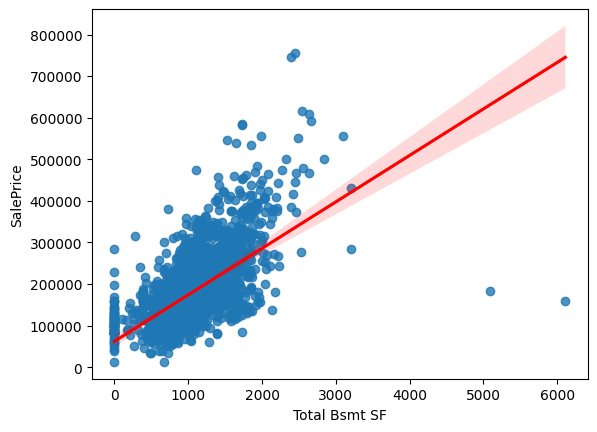

In [136]:
sns.regplot(x='Total Bsmt SF', y='SalePrice', data=train_temp, line_kws={"color": "red"})

In [137]:
train_temp.query('`Total Bsmt SF` > 6000')

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1498,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [138]:
outliers_total_bsmt_sf = train_temp.query('`Total Bsmt SF` > 6000').index
for idx in outliers_total_bsmt_sf:
    homes_to_drop.add(idx)

<Axes: xlabel='1st Flr SF', ylabel='SalePrice'>

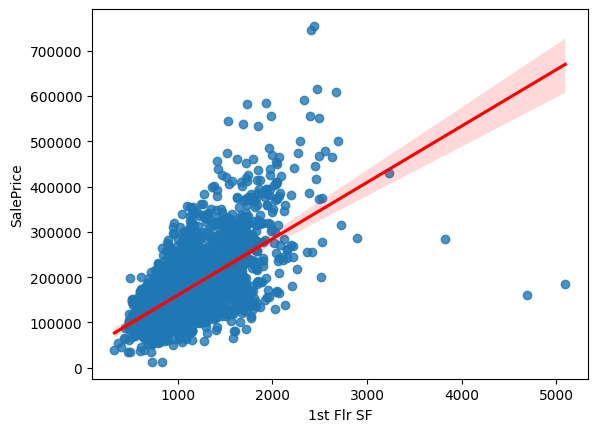

In [139]:
sns.regplot(x='1st Flr SF', y='SalePrice', data=train_temp, line_kws={"color": "red"})

In [140]:
train_temp.query('`1st Flr SF` > 4000')

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1498,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
2180,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850


In [141]:
outliers_1st_flr_sf = train_temp.query('`1st Flr SF` > 4000').index
for idx in outliers_1st_flr_sf:
    homes_to_drop.add(idx)

<Axes: xlabel='Gr Liv Area', ylabel='SalePrice'>

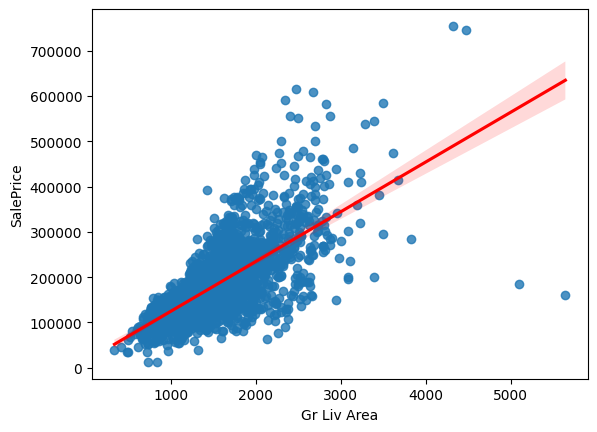

In [142]:
sns.regplot(x='Gr Liv Area', y='SalePrice', data=train_temp, line_kws={"color": "red"})

In [143]:
train_temp.query('`Gr Liv Area` > 4000 & `SalePrice` < 200000')

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1498,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
2180,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850


In [144]:
outliers_gr_liv_area = train_temp.query('`Gr Liv Area` > 4000 & `SalePrice` < 200000').index
for idx in outliers_gr_liv_area:
    homes_to_drop.add(idx)

<Axes: xlabel='Bedroom AbvGr', ylabel='SalePrice'>

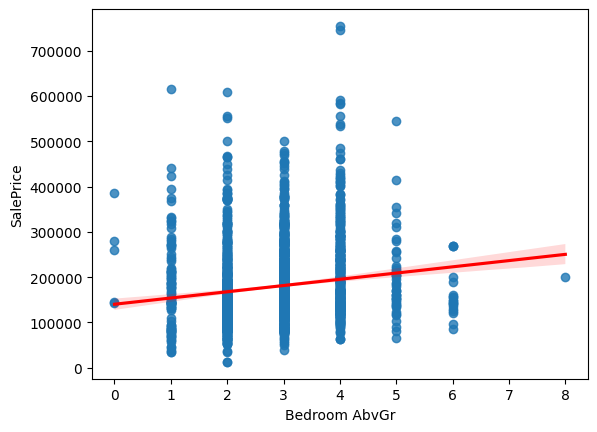

In [145]:
sns.regplot(x='Bedroom AbvGr', y='SalePrice', data=train_temp, line_kws={"color": "red"})

In [146]:
train_temp.query('`Bedroom AbvGr` == 8')

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2194,2195,909176080,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


In [147]:
outliers_bedroom_abvgr = train_temp.query('`Bedroom AbvGr` == 8').index
for idx in outliers_bedroom_abvgr:
    homes_to_drop.add(idx)

<Axes: xlabel='TotRms AbvGrd', ylabel='SalePrice'>

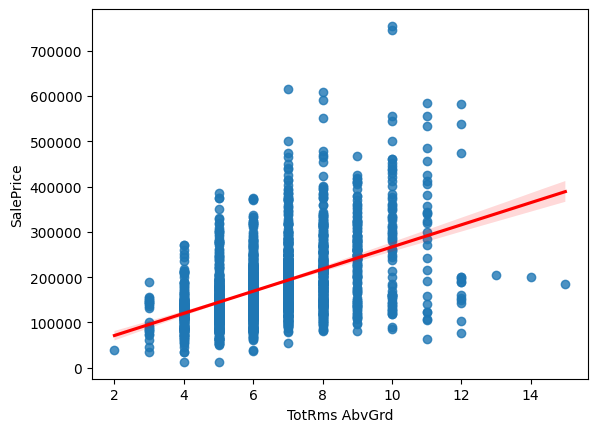

In [148]:
sns.regplot(x='TotRms AbvGrd', y='SalePrice', data=train_temp, line_kws={"color": "red"})

In [149]:
train_temp.query('`TotRms AbvGrd` > 12')

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
925,926,909279010,90,RL,NaN,8145,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,205000
2194,2195,909176080,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000
2180,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850


In [150]:
outliers_totrms_abvgrd = train_temp.query('`TotRms AbvGrd` > 12').index
for idx in outliers_totrms_abvgrd:
    homes_to_drop.add(idx)

Identified Outliers:

* Lot Frontage: homes with exceptionally large lot frontage

* Lot Area: properties with unusually large land areas compared to their low sale price

* Overall Quality: homes rated highly in quality bu sold at lower prices

* Total Basement SF, 1st Floor SF, Gr Liv Area: homes with very large square footage values compared to sale price

* Bedrooms Above Ground, Total Rooms Above Ground: homes with unusually high room counts

In [151]:
print(f"Homes to drop: {homes_to_drop}")
print(f"Number of homes to drop: {len(homes_to_drop)}")

Homes to drop: {1570, 2115, 2180, 1265, 2194, 2071, 1498, 956, 925}
Number of homes to drop: 9


Now I am going to drop the outliers from the training data only. Removing these outliers helps in reducing the variance in the dataset, leading to more stable and generalizable models.

In [152]:
X_train_clean = X_train_raw.drop(index=homes_to_drop, errors='ignore')
y_train_clean = y_train_raw.drop(index=homes_to_drop, errors='ignore')

# Missing Values

* Missing values can introduce biases and reduce the effectiveness of models so I want to identify and handle these values appropriately either through imputation or removal

In [153]:
missing_values_df = pd.DataFrame(data.isnull().sum().sort_values(ascending=False)).head(30)
print("Top 30 Features with Missing Values:\n")
missing_values_df

Top 30 Features with Missing Values:



,0
Pool QC,2917
Misc Feature,2824
Alley,2732
Fence,2358
Mas Vnr Type,1775
Fireplace Qu,1422
Lot Frontage,490
Garage Cond,159
Garage Finish,159
Garage Yr Blt,159


Lets look at the all of the features with more than a thousand missing values and list their unique labels below.

In [154]:
print("Pool QC Unique Values:", data['Pool QC'].unique())
print("Misc Feature Unique Values:", data['Misc Feature'].unique())
print("Fence Unique Values:", data['Fence'].unique())
print("Mas Vnr Type Unique Values:", data['Mas Vnr Type'].unique())
print("Fireplace Qu Unique Values:", data['Fireplace Qu'].unique())

Pool QC Unique Values: [nan 'Ex' 'Gd' 'TA' 'Fa']
Misc Feature Unique Values: [nan 'Gar2' 'Shed' 'Othr' 'Elev' 'TenC']
Fence Unique Values: [nan 'MnPrv' 'GdPrv' 'GdWo' 'MnWw']
Mas Vnr Type Unique Values: ['Stone' nan 'BrkFace' 'BrkCmn' 'CBlock']
Fireplace Qu Unique Values: ['Gd' nan 'TA' 'Po' 'Ex' 'Fa']


From the above lists I think I will drop Misc Feature completely since nearly all of the homes are missing a value for this feature. Additionally the documents for the dataset show various features that are included are things like "tennis court" or other extravagant features which are obviously not common amongst most homes.

In [155]:
X_train_clean.drop(columns=['Misc Feature'], inplace=True)
X_test_raw.drop(columns=['Misc Feature'], inplace=True)
print(f"Training set shape after dropping certain features: {X_train_clean.shape}")

Training set shape after dropping certain features: (2628, 80)


# Feature Engineering

Creating new features can highlight hidden relationships and make the data easier to work with overall. Below I will create new features that I think will be predicitve. These features will be derived from existing ones that can then be removed.

In [156]:
# Add new features to both the train and test sets
def fe(df):
    data_copy = df.copy()
    if '1st Flr SF' in data_copy.columns and '2nd Flr SF' in data_copy.columns and 'Total Bsmt SF' in data_copy.columns:
        data_copy['Total SF'] = data_copy['1st Flr SF'] + data_copy['2nd Flr SF'] + data_copy['Total Bsmt SF']
    if all(c in data_copy.columns for c in ['3Ssn Porch', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch']):
        data_copy['Total Porch SF'] = data_copy['3Ssn Porch'] + data_copy['Open Porch SF'] + data_copy['Enclosed Porch'] + data_copy['Screen Porch']
    if all(c in data_copy.columns for c in ['Full Bath','Half Bath','Bsmt Full Bath','Bsmt Half Bath']):
        data_copy['Total Bathrooms'] = data_copy['Full Bath'] + (0.5 * data_copy['Half Bath']) + data_copy['Bsmt Full Bath'] + (0.5 * data_copy['Bsmt Half Bath'])
    if all(c in data_copy.columns for c in ['Yr Sold','Year Built']):
        data_copy['House Age'] = data_copy['Yr Sold'] - data_copy['Year Built']
    if 'Garage Yr Blt' in data_copy.columns and 'Yr Sold' in data_copy.columns:
        data_copy['Garage Age'] = data_copy['Yr Sold'] - data_copy['Garage Yr Blt']
    if 'Year Remod/Add' in data_copy.columns and 'Yr Sold' in data_copy.columns:
        data_copy['Remodel Age'] = data_copy['Yr Sold'] - data_copy['Year Remod/Add']
    data_copy['Has Fence'] = data_copy['Fence'].notna().astype(int) if 'Fence' in data_copy.columns else 0

    # Drop redundant features after engineering
    cols_to_drop = [
        'PID', 'Fence', 'Order', 'Yr Sold', 'Year Built', '1st Flr SF',
        '2nd Flr SF', 'Total Bsmt SF', 'Full Bath', 'Half Bath',
        'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Year Remod/Add',
        '3Ssn Porch', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch'
    ]
    for c in cols_to_drop:
        if c in data_copy.columns:
            data_copy.drop(columns=c, inplace=True, errors='ignore')
    return data_copy

In [157]:
X_train_fe = fe(X_train_clean)
X_test_fe = fe(X_test_raw)

In [158]:
print(f"Training set shape after feature engineering: {X_train_fe.shape}")
print(f"Testing set shape after feature engineering: {X_test_fe.shape}")

Training set shape after feature engineering: (2628, 69)
Testing set shape after feature engineering: (293, 69)


In [159]:
# Log transform SalePrice
y_train_log = np.log1p(y_train_clean)
y_test_log = np.log1p(y_test_raw)

Lets look at a correlation matrix of my numerical features.

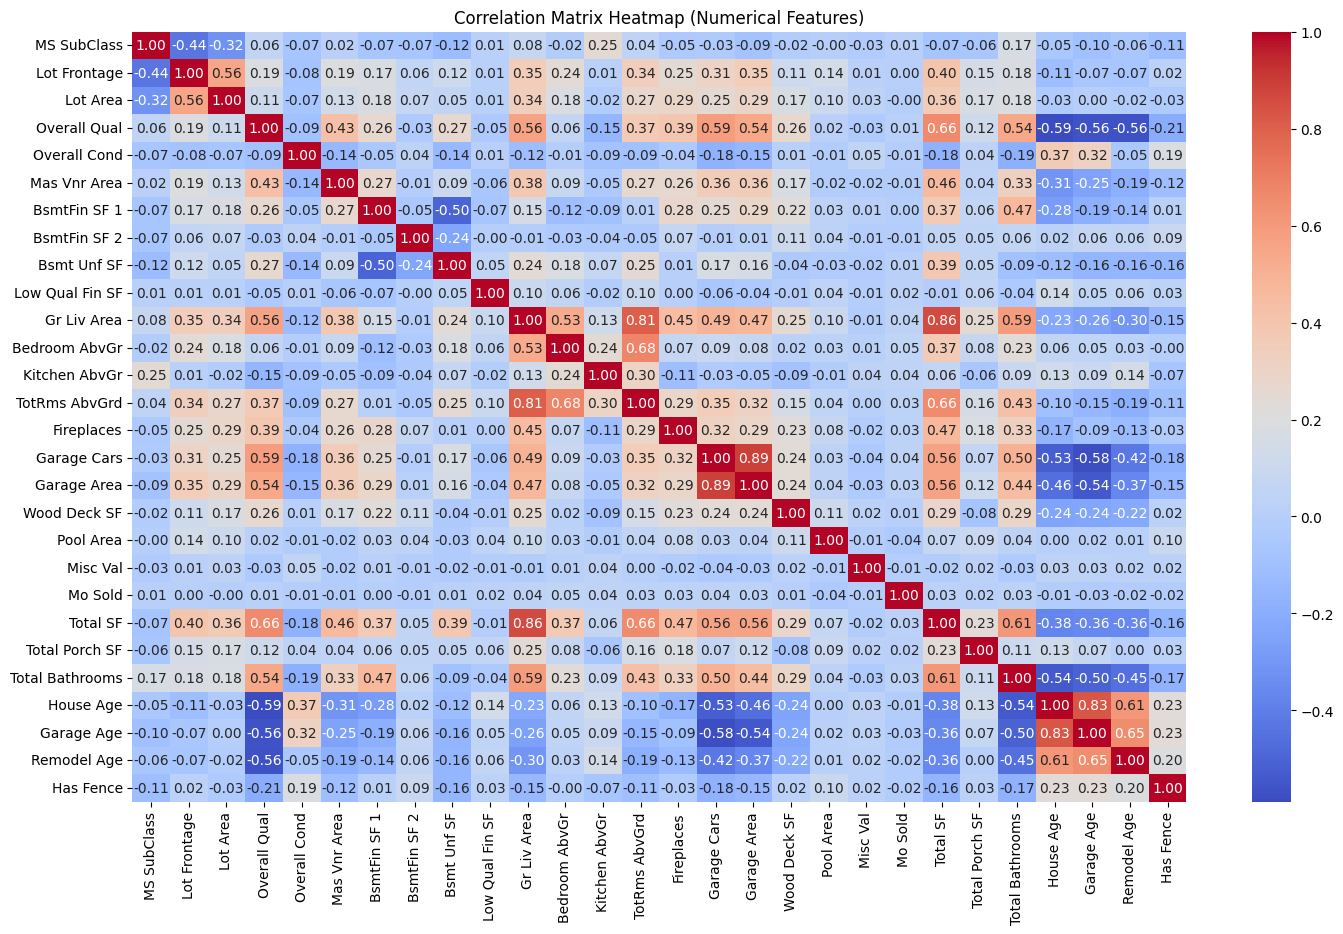

In [160]:
numerical_features = X_train_fe.select_dtypes(include=['float64', 'int64']).columns

corr_matrix_num = X_train_fe[numerical_features].corr()

plt.figure(figsize=(17, 10))
sns.heatmap(corr_matrix_num, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap (Numerical Features)')
plt.show()

I can see that there is one redundant feature that I can remove (Gr Liv Area) which is above ground living area that correlates highly with my new feature Total SF. Additionally, Garage Area and Garage Cars are also highly correlated so I will choose to remove Garage Cars since the total garage area encompasses the number of cars it can hold.

In [161]:
for c in ['Gr Liv Area', 'Garage Cars']:
    if c in X_train_fe.columns:
        X_train_fe.drop(columns=[c], inplace=True, errors='ignore')
        X_test_fe.drop(columns=[c], inplace=True, errors='ignore')

In [162]:

print(X_train_fe.shape, X_test_fe.shape)

(2628, 67) (293, 67)


Newly Engineered Features:

* Total SF: Sum of 1st Flr SF, 2nd Flr SF, and Total Bsmt SF to represent the overall square footage of the home

* Total Porch SF: Summed square footage of all porch types to represent outdoor living space

* Total Bathrooms: Combines full baths, half baths, and basement bathrooms to quantify bathroom availability

* House Age: Difference between Yr Sold and Year Built to represent property age

* Garage Age: Time since garage construction, calculated from Garage Yr Blt

* Remodel Age: Time since the last remodeling, derived from Year Remod/Add

* Has Fence: Binary indicator representing the presence of a fence

Redundant Features Removed:

* Features highly correlated with engineered ones, such as Gr Liv Area and Garage Cars, were removed


# Data Imputation / Encoding

* Before modeling we need to prepare the data further which involves handling missing values, encoding categorical data, and scaling numerical data

Lets  identify our categorical/numerical features and split them into one-hot / ordinal encoding lists

In [163]:
numerical_features = X_train_fe.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train_fe.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Low Qual Fin SF', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Area', 'Wood Deck SF', 'Pool Area', 'Misc Val', 'Mo Sold', 'Total SF', 'Total Porch SF', 'Total Bathrooms', 'House Age', 'Garage Age', 'Remodel Age', 'Has Fence']
Categorical Features: ['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Sa

In [164]:
categorical_ord = [
    'Land Slope', 'Land Contour', 'Lot Shape',
    'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
    'Bsmt Exposure', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu',
    'Garage Qual', 'Garage Cond'
]

categorical_oh = list(set(categorical_features) - set(categorical_ord))
print("Ordinal Categorical Features:", categorical_ord)
print("One Hot Categorical Features:", categorical_oh)

Ordinal Categorical Features: ['Land Slope', 'Land Contour', 'Lot Shape', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual', 'Garage Cond']
One Hot Categorical Features: ['Lot Config', 'Exterior 2nd', 'Exterior 1st', 'Garage Type', 'Condition 2', 'Pool QC', 'Foundation', 'BsmtFin Type 2', 'Sale Condition', 'Functional', 'Roof Matl', 'Utilities', 'Neighborhood', 'Bldg Type', 'Street', 'Sale Type', 'MS Zoning', 'Heating', 'BsmtFin Type 1', 'Condition 1', 'Central Air', 'Roof Style', 'Electrical', 'House Style', 'Garage Finish', 'Mas Vnr Type', 'Alley', 'Paved Drive']


For our ordinal encoding we will need a mapping to use for each feature. We can look at each feature's unique labels and create our mapping.

In [165]:
# Print unique labels to find missing values
for col in categorical_ord:
    print(f"{col}: {data[col].unique()})")

Land Slope: ['Gtl' 'Mod' 'Sev'])
Land Contour: ['Lvl' 'HLS' 'Bnk' 'Low'])
Lot Shape: ['IR1' 'Reg' 'IR2' 'IR3'])
Exter Qual: ['TA' 'Gd' 'Ex' 'Fa'])
Exter Cond: ['TA' 'Gd' 'Fa' 'Po' 'Ex'])
Bsmt Qual: ['TA' 'Gd' 'Ex' nan 'Fa' 'Po'])
Bsmt Cond: ['Gd' 'TA' nan 'Po' 'Fa' 'Ex'])
Bsmt Exposure: ['Gd' 'No' 'Mn' 'Av' nan])
Heating QC: ['Fa' 'TA' 'Ex' 'Gd' 'Po'])
Kitchen Qual: ['TA' 'Gd' 'Ex' 'Fa' 'Po'])
Fireplace Qu: ['Gd' nan 'TA' 'Po' 'Ex' 'Fa'])
Garage Qual: ['TA' nan 'Fa' 'Gd' 'Ex' 'Po'])
Garage Cond: ['TA' nan 'Fa' 'Gd' 'Ex' 'Po'])


In [166]:
# Ordinal Mappings
ordinal_mappings = {
    'Exter Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Exter Cond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Bsmt Qual': ['No', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Bsmt Cond': ['No', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Bsmt Exposure': ['Av', 'Gd', 'Mn', 'No'],
    'Heating QC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Kitchen Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fireplace Qu': ['No', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Garage Qual': ['No', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Garage Cond': ['No', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Land Slope': ['Sev', 'Mod', 'Gtl'],
    'Land Contour': ['Low', 'Lvl', 'HLS', 'Bnk'],
    'Lot Shape': ['IR3', 'IR2', 'IR1', 'Reg']
}

In [167]:
oe_cats = [ordinal_mappings[col] for col in categorical_ord if col in ordinal_mappings]
oe = OrdinalEncoder(categories=oe_cats)

In [168]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [169]:
ord_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='No')),
    ('ord', oe)
])

In [170]:
oh_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [171]:
feature_transformer = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('ord', ord_pipeline, categorical_ord),
    ('oh', oh_pipeline, categorical_oh)
])

**Processing Steps:**

**-> Numerical Features:**

* Imputation: Missing values were filled using the mean strategy

* Scaling: Applied StandardScaler to normalize feature distributions

**-> Categorical Features:**

* Ordinal Encoding: Applied to features with an inherent order (i.e. quality categories) using OrdinalEncoder

* One-Hot Encoding: Used for nominal categorical variables without an intrinsic order using OneHotEncoder

* Imputation: Categorical missing values were filled with 'No' or the most frequent category as appropriate indicating that a home was missing that feature


**Feature Transformation Pipeline:**

* A ColumnTransformer was employed to apply different preprocessing steps to numerical and categorical features seamlessly within a pipeline

# Initial Model Implementations

* Here I will try a few basic implementations of some models using cross val and see which ones perform the best to use for hyperparameter tuning

**Models Evaluated:**

* Ridge Regression: Linear model with L2 regularization

* Lasso Regression: Linear model with L1 regularization

* Elastic Net: Combines L1 and L2 regularization

* Random Forest Regressor: Ensemble of decision trees

* XGBoost Regressor: Gradient boosting framework

**Evaluation Metrics:**

* R² Score: Measures the proportion of variance explained by the model

* Mean Absolute Error (MAE): Average absolute differences between predicted and actual values

* Mean Squared Error (MSE): Average squared differences, penalizing larger errors

In [173]:
models = {
    'ridge': Ridge(random_state=42),
    'lasso': Lasso(random_state=42),
    'rfr': RandomForestRegressor(random_state=42),
    'xgb': XGBRegressor(random_state=42),
    'elastic': ElasticNet(random_state=42)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocess', feature_transformer),
        ('model', model)
    ])

    y_cv_pred_log = cross_val_predict(pipeline, X_train_fe, y_train_log, cv=cv)

    y_cv_pred = np.expm1(y_cv_pred_log)
    y_cv_true = np.expm1(y_train_log)

    cv_r2 = r2_score(y_cv_true, y_cv_pred)
    cv_mae = mean_absolute_error(y_cv_true, y_cv_pred)
    cv_rmse = np.sqrt(mean_squared_error(y_cv_true, y_cv_pred))

    results.append({
        'Model': name,
        'CV R²': cv_r2,
        'CV MAE': cv_mae,
        'CV RMSE': cv_rmse
    })

results_df = pd.DataFrame(results)

results_df

AttributeError: 'super' object has no attribute '__sklearn_tags__'

# Hyperparameter Tuning

From the results above I can see that the Ridge, XGBoost Regressor, and Random Forest Regressor performed the best out of the 5. They all had low MAE outputs relative to a home sale price which indicates that the average absolute error is small suggesting good predictive accuracy. Additionally, they have consistently small MSE outputs which is indicates that the models are capturing the variance well. Lastly, they all have relatively high r^2 values which tell me that they are fitting the data well but there is a chance that overfitting could be occuring. 

For Ridge, Random Forest, and XGBoost I will use hyperparameter tuning to see if I can get better performance from them since they are currently unoptimized.

**Grid Search Configuration:**

* Scoring: Optimized for the highest R² score

* Cross-Validation: 5-fold with shuffling

* Parallelization: Utilized all available CPU cores (n_jobs=-1) for efficiency

**Ridge Regressor:**

-> Parameters Tuned:

* alpha: 

In [287]:
ridge_pipeline = Pipeline(steps=[
    ('preprocess', feature_transformer),
    ('ridge', Ridge(random_state=42))
])

In [288]:
ridge_params = {
    'ridge__alpha': [0.1, 1.0, 5, 10, 15, 20, 30, 50]
}

scoring = {'r2': 'r2', 'mae': 'neg_mean_absolute_error', 'mse': 'neg_mean_squared_error'}

ridge_cv = GridSearchCV(ridge_pipeline, ridge_params, scoring=scoring, refit='r2', cv=5, n_jobs=-1, verbose=1)

ridge_cv.fit(X_train_fe, y_train_log)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MS '
                                                                          'SubClass',
                                                                          'Lot '
                                                                          'Frontage',
                                                                          'Lot '
                                                                          'Area',
                                                                          'Overall '
                                                                          'Qual',
                                                                          'Overall '
                                                                          'Cond',
                                                                          'Mas '
                                                                          'Vnr '
                                                                          'Area',
                                                                          'BsmtFin '
                                                                          'SF '
                                                                          '1',
                                                                          'BsmtFin '
                                                                          'SF '
                                                                          '2',
                                                                          'Bsmt '
                                                                          'Unf '
                                                                          'SF',
                                                                          'Low '
                                                                          'Qual '
                                                                          'Fin '
                                                                          'SF',
                                                                          'Bedroom '
                                                                          'AbvGr...
                                                                          'Style',
                                                                          'Condition '
                                                                          '1',
                                                                          'Street',
                                                                          'Garage '
                                                                          'Finish',
                                                                          'BsmtFin '
                                                                          'Type '
                                                                          '2',
                                                                          'Electrical',
                                                                          'Alley',
                                                                          'Exterior '
                                                                          '2nd',
                                            

In [289]:
print("Best Ridge Params:", ridge_cv.best_params_)
best_ridge_model = ridge_cv.best_estimator_

Best Ridge Params: {'ridge__alpha': 15}


**Random Forest Regressor:**

-> Parameters Tuned:

* n_estimators: Number of trees in the forest

* max_depth: Maximum depth of the trees

* min_samples_split: Minimum number of samples required to split an internal node

In [290]:
rfr_pipeline = Pipeline(steps=[
    ('preprocess', feature_transformer),
    ('rfr', RandomForestRegressor(random_state=42))
])

In [291]:
rfr_params = {
    'rfr__n_estimators': [100,200,300,500],
    'rfr__max_depth': [5,10,15,20,30],
    'rfr__min_samples_split': [2,3,4]
}
scoring = {'r2': 'r2', 'mae': 'neg_mean_absolute_error', 'mse': 'neg_mean_squared_error'}

rfr_cv = GridSearchCV(rfr_pipeline, rfr_params, scoring=scoring, refit='r2', cv=5, n_jobs=-1, verbose=1)
rfr_cv.fit(X_train_fe, y_train_log)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MS '
                                                                          'SubClass',
                                                                          'Lot '
                                                                          'Frontage',
                                                                          'Lot '
                                                                          'Area',
                                                                          'Overall '
                                                                          'Qual',
                                                                          'Overall '
                                                                          'Cond',
                                                                          'Mas '
                                                                          'Vnr '
                                                                          'Area',
                                                                          'BsmtFin '
                                                                          'SF '
                                                                          '1',
                                                                          'BsmtFin '
                                                                          'SF '
                                                                          '2',
                                                                          'Bsmt '
                                                                          'Unf '
                                                                          'SF',
                                                                          'Low '
                                                                          'Qual '
                                                                          'Fin '
                                                                          'SF',
                                                                          'Bedroom '
                                                                          'AbvGr...
                                                                          'Electrical',
                                                                          'Alley',
                                                                          'Exterior '
                                                                          '2nd',
                                                                          'Neighborhood',
                                                                          'Functional',
                                                                          'Heating'])])),
                                       ('rfr',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rfr__max_depth': [5, 10, 15, 20, 30],
                         'rfr__min_samples_split': [2, 3, 4],
                         'rfr__n_estimators': [100, 200, 300, 500]},
             refit='r2',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error', 'r2': 'r2'},
             verbose=1)

In [292]:
print("Best RFR Params:", rfr_cv.best_params_)
best_rfr_model = rfr_cv.best_estimator_

Best RFR Params: {'rfr__max_depth': 20, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 200}


**XGBoost Regressor:**

-> Parameters Tuned:

* max_depth: Maximum depth of a tree

* n_estimators: Number of gradient boosted trees

* learning_rate: Step size shrinkage used to prevent overfitting

In [293]:
xgb_pipeline = Pipeline(steps=[
    ('preprocess', feature_transformer),
    ('xgb', XGBRegressor(random_state=42))
])

In [294]:
xgb_params = {
    'xgb__max_depth': [2,3,4,5],
    'xgb__n_estimators': [100,200,400,300,500],
    'xgb__learning_rate': [0.01,0.1]
}
scoring = {'r2': 'r2', 'mae': 'neg_mean_absolute_error', 'mse': 'neg_mean_squared_error'}

xgb_cv = GridSearchCV(xgb_pipeline, xgb_params, scoring=scoring, refit='r2', cv=5, n_jobs=-1, verbose=1)
xgb_cv.fit(X_train_fe, y_train_log)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MS '
                                                                          'SubClass',
                                                                          'Lot '
                                                                          'Frontage',
                                                                          'Lot '
                                                                          'Area',
                                                                          'Overall '
                                                                          'Qual',
                                                                          'Overall '
                                                                          'Cond',
                                                                          'Mas '
                                                                          'Vnr '
                                                                          'Area',
                                                                          'BsmtFin '
                                                                          'SF '
                                                                          '1',
                                                                          'BsmtFin '
                                                                          'SF '
                                                                          '2',
                                                                          'Bsmt '
                                                                          'Unf '
                                                                          'SF',
                                                                          'Low '
                                                                          'Qual '
                                                                          'Fin '
                                                                          'SF',
                                                                          'Bedroom '
                                                                          'AbvGr...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [2, 3, 4, 5],
                         'xgb__n_estimators': [100, 200, 400, 300, 500]},
             refit='r2',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error', 'r2': 'r2'},
             verbose=1)

In [295]:
print("Best XGB Params:", xgb_cv.best_params_)
best_xgb_model = xgb_cv.best_estimator_

Best XGB Params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 400}


**Outcome:**

The best parameters for each model were identified based on cross-validation performance, setting the stage for final model evaluation.

# Test Set Evaluation

After selecting the best models through cross-validation and hyperparameter tuning, I will evaluate their performance on the unseen test set to assess generalization capabilities.

**Evaluation Metrics on Test Set:**

* Mean Absolute Error (MAE): Indicates the average magnitude of errors in predictions

* Root Mean Squared Error (RMSE): Provides insight into the standard deviation of prediction errors

* R² Score: Reflects the proportion of variance explained by the model on the test data

In [296]:
tuned_results = []

tuned_models = [
    ('Ridge Regression', best_ridge_model, ridge_cv),
    ('Random Forest Regressor', best_rfr_model, rfr_cv),
    ('XGBoost Regressor', best_xgb_model, xgb_cv)
]

for name, model, grid_search in tuned_models:

    y_cv_pred_log = cross_val_predict(model, X_train_fe, y_train_log, cv=cv, n_jobs=-1)

    y_cv_pred = np.expm1(y_cv_pred_log)
    y_cv_true = np.expm1(y_train_log)

    cv_r2 = r2_score(y_cv_true, y_cv_pred)
    cv_mae = mean_absolute_error(y_cv_true, y_cv_pred)
    cv_rmse = np.sqrt(mean_squared_error(y_cv_true, y_cv_pred))

    y_test_pred_log = model.predict(X_test_fe)
    y_test_pred = np.expm1(y_test_pred_log)

    test_r2 = r2_score(y_test_raw, y_test_pred)
    test_mae = mean_absolute_error(y_test_raw, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

    tuned_results.append({
        'Model': name,
        'CV R²': cv_r2,
        'CV MAE': cv_mae,
        'CV RMSE': cv_rmse,
        'Test R²': test_r2,
        'Test MAE': test_mae,
        'Test RMSE': test_rmse
    })

tuned_results_df = pd.DataFrame(tuned_results)

print("Hyperparameter-Tuned Models Test Set Results:")
tuned_results_df


Hyperparameter-Tuned Models Test Set Results:


,Model,CV R²,CV MAE,CV RMSE,Test R²,Test MAE,Test RMSE
0,Ridge Regression,0.938393,13222.132308,19546.941412,0.565618,16034.762775,58204.130512
1,Random Forest Regressor,0.907007,15483.270714,24015.300700,0.856289,16683.942816,33478.256370
2,XGBoost Regressor,0.925338,13640.061124,21518.456528,0.861826,13815.348110,32826.971979


**Comparative Summary**

* Ridge Regressor: The Ridge performed very well in its base cross validation with a high R² score and low MAE/RMSE values. However, there was a significant drop in test performance indicating that the model generalize well on unseen data

* Random Forest Regressor: The RFR also performed well in its base cross validation but had moderate MAW/RMSE values compared to the Ridge highlighting the inherent differences between linear and tree-based models. The test performance was much better though with a high test R² score and low RMSE value indicating that the model generalizes better on unseen data

* XGBoost Regressor: The XGB performed the best of the three with a great R² score and the lowest MAE value showing that it generalizes on unseen data well and had more accruate predictions on average

# Final Thoughts

In this project I aimed to predict the sale price of homes in Ames, Iowa using a large dataset of approximately 80 features describing various property characterisitcs. My primary goal was to develop a regression model to acheive this.

Throughout the project I had several key steps:

1. **Data Exploration and Cleaning**
2. **Outlier Detection**
3. **Feature Engineering**
4. **Data Imputation / Encoding**
5. **Modeling and Hyperparameter Tuning**
6. **Test Set Evaluation**

The performance of the XGBoost model highlighted the complexity of the relationship between sale price and the various property characteristics. I learned a lot during the data preprocessing and feature engineering steps and I'm sure there is room for improvement regarding my approach in those two areas. Even though I spent many hours trying different methods for preproccessing the data and cleaning I think I was able to succeed in the end in not altering the data too much from the original dataset which allowed me to obtain good results from my models. 

The Ames Housing Dataset is large and rich in features but the limitations it does have would require me to use a lot more data in the future if I wanted to expand on the project. Also, a different preprocessing approach could have allowed me to yield different results altogether. Performing feature engineering I thought was a important step for this dataset as there is a lot of multicollinearity to begin with. 

During my hyperpameter tuning I spent a lot of time trying various combinations and ranges of values to include in my grid search. I struggled the most with this stage since I never felt like I was making the right choices and it was hard to see patterns in the changes I saw in the best parameters. With further refinements in model tuning and possibly adding additional features it may be possible to improve the model’s performance even further. There were other models that I wanted to try such as CatBoost but I was unable to successfully pip install them so it limited me somewhat unfortunately. 

I think this project demonstrates a solid approach to regression modeling and will allow for continued experimentation in predictive analytics. I had a lot of fun during this project I will look forward to applying what I've learned to future school/personal projects!